# LEZIONE 12 — Overfitting e Underfitting

## Obiettivi della Lezione

Al termine di questa lezione sarai in grado di:

1. **Comprendere** il trade-off tra bias e varianza
2. **Riconoscere** i segnali di overfitting e underfitting nei dati
3. **Interpretare** le curve di apprendimento (learning curves)
4. **Diagnosticare** problemi di generalizzazione nei modelli
5. **Scegliere** la complessità appropriata per un modello

## Perché è Importante

L'overfitting è **il problema centrale** del machine learning:

- Un modello che memorizza invece di generalizzare è **inutile in produzione**
- La differenza tra un data scientist junior e uno senior sta nella capacità di **diagnosticare e prevenire** questi problemi
- Senza questa comprensione, non puoi interpretare correttamente i risultati dei tuoi modelli

## Posizione nel Percorso

```
Lezione 11: Validazione (COME misurare)
    ↓
→ Lezione 12: Overfitting (COSA può andare storto) ← SEI QUI
    ↓
Lezione 13: Pipeline (COME strutturare il workflow)
```

---

## Librerie Utilizzate

```python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, mean_squared_error
```

# Section 1 — Il Problema Fondamentale: Generalizzazione

## Cosa Vogliamo Davvero da un Modello?

L'obiettivo del machine learning **non è** predire bene i dati che il modello ha già visto.
L'obiettivo è predire bene **dati nuovi, mai visti**.

Questa capacità si chiama **generalizzazione**.

```
               TRAINING DATA                    NUOVI DATI
              ┌─────────────┐                 ┌─────────────┐
              │ ● ● ● ● ● ● │                 │ ? ? ? ? ? ? │
              │ ● ● ● ● ● ● │  ─► Modello ─►  │ ? ? ? ? ? ? │
              │ ● ● ● ● ● ● │                 │ ? ? ? ? ? ? │
              └─────────────┘                 └─────────────┘
                   Noti                          Ignoti
                   
         Performance qui ≠ Performance qui!
```

## Due Modi per Fallire

### 1. UNDERFITTING (Bias Alto)

Il modello è **troppo semplice** per catturare i pattern reali:

```
Dati reali: curva complessa
Modello: retta

         │    ●
    y    │  ●   ●●
         │●───────●───  ← Retta (underfitting)
         │    ●     ●●
         └───────────────
                 x
                 
Errore alto sia su train che su test!
```

**Segnali:**
- Errore alto sul training set
- Errore alto sul test set
- I due errori sono simili

### 2. OVERFITTING (Varianza Alta)

Il modello è **troppo complesso** e memorizza il rumore:

```
Dati reali: curva semplice + rumore
Modello: curva che passa per ogni punto

         │    ●
    y    │  ●╱ ╲●●
         │●╱    ╲●╱╲  ← Curva troppo complessa (overfitting)
         │        ╲●●
         └───────────────
                 x
                 
Errore basso su train, ALTO su test!
```

**Segnali:**
- Errore basso sul training set
- Errore alto sul test set
- Grande gap tra i due errori

# Section 2 — Bias vs Varianza: Il Trade-Off

## Decomposizione dell'Errore

L'errore totale di un modello può essere scomposto in tre componenti:

$$\text{Errore Totale} = \text{Bias}^2 + \text{Varianza} + \text{Rumore Irriducibile}$$

### Bias (Errore Sistematico)

Il **bias** misura quanto le predizioni del modello si discostano sistematicamente dai valori reali.

- **Bias alto** = modello troppo semplice, non cattura i pattern
- **Bias basso** = modello flessibile, cattura bene i pattern

```
Bias Alto:                    Bias Basso:
    │ ● ●                        │ ● ●
    │───●─●──  ← previsioni      │ ●───●
    │  ●   ●      lontane        │   ●  ●  ← previsioni
    │ ●      ●    dal vero       │ ●      ●  vicine al vero
```

### Varianza (Sensibilità ai Dati)

La **varianza** misura quanto le predizioni cambiano se alleni il modello su dati diversi.

- **Varianza alta** = modello instabile, cambia molto con dati diversi
- **Varianza bassa** = modello stabile, predizioni consistenti

```
Varianza Bassa:               Varianza Alta:
(3 training diversi)          (3 training diversi)

    │ ───                          │  ╱╲
    │ ───  ← tutte simili          │ ─╱─╲─  ← molto diverse
    │ ───                          │   ╲╱
```

## Il Trade-Off

**Non puoi minimizzare entrambi contemporaneamente!**

```
Errore │
       │ ╲                    ╱
       │  ╲   Bias²          ╱ Varianza
       │   ╲               ╱
       │    ╲            ╱
       │     ╲    ★    ╱   ← Punto ottimo
       │      ╲──────╱
       │        ╲╱ Errore Totale
       └───────────────────────────
              Complessità Modello →
              
    Semplice ◄────────────────► Complesso
    (Underfitting)              (Overfitting)
```

| Complessità | Bias | Varianza | Rischio |
|-------------|------|----------|---------|
| Troppo bassa | Alto | Bassa | Underfitting |
| Giusta | Bilanciato | Bilanciato | Generalizzazione |
| Troppo alta | Basso | Alta | Overfitting |

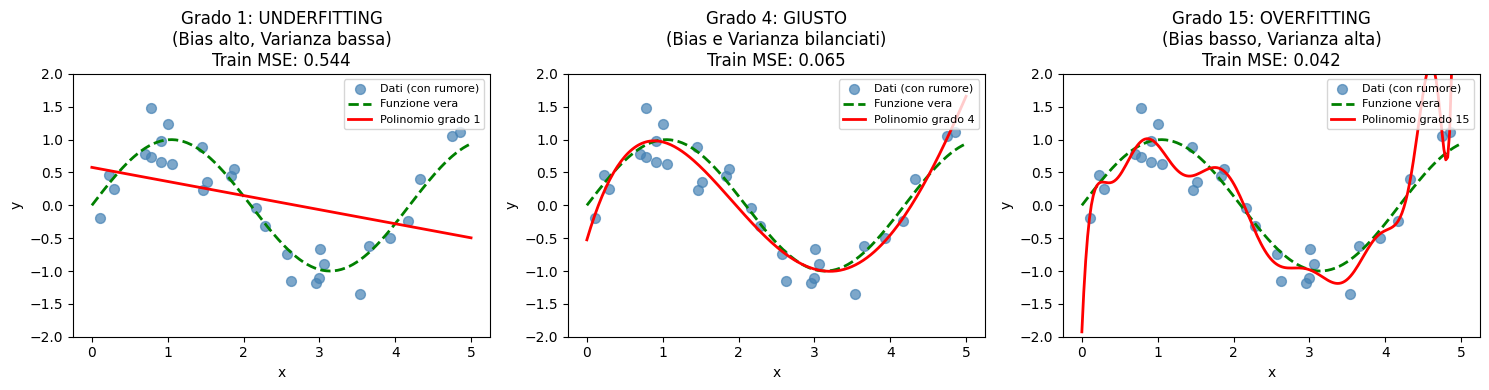

INTERPRETAZIONE

• GRADO 1 (Underfitting):
  - Modello troppo semplice (una retta)
  - Non cattura la curva sinusoidale
  - Errore alto anche sul training set

• GRADO 4 (Giusto):
  - Complessità adeguata
  - Cattura il pattern senza seguire il rumore
  - Buon compromesso

• GRADO 15 (Overfitting):
  - Modello troppo complesso
  - Passa per (quasi) tutti i punti → basso errore di training
  - Ma oscilla selvaggiamente tra i punti
  - Pessime predizioni su dati nuovi!



In [1]:
# Dimostrazione: Bias vs Varianza con Regressione Polinomiale

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# Funzione vera (che il modello NON conosce)
np.random.seed(42)
def true_function(x):
    return np.sin(1.5 * x)

# Generiamo dati con rumore
n_samples = 30
X = np.sort(np.random.uniform(0, 5, n_samples))
y = true_function(X) + np.random.normal(0, 0.3, n_samples)

# Punti per visualizzazione
X_plot = np.linspace(0, 5, 200)

# Confrontiamo 3 gradi di polinomio
degrees = [1, 4, 15]
titles = ['Grado 1: UNDERFITTING\n(Bias alto, Varianza bassa)', 
          'Grado 4: GIUSTO\n(Bias e Varianza bilanciati)',
          'Grado 15: OVERFITTING\n(Bias basso, Varianza alta)']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, degree, title in zip(axes, degrees, titles):
    # Crea modello polinomiale
    model = make_pipeline(
        PolynomialFeatures(degree),
        LinearRegression()
    )
    
    # Allena
    model.fit(X.reshape(-1, 1), y)
    
    # Predici
    y_pred = model.predict(X_plot.reshape(-1, 1))
    y_train_pred = model.predict(X.reshape(-1, 1))
    
    # Calcola errori
    train_mse = mean_squared_error(y, y_train_pred)
    
    # Plot
    ax.scatter(X, y, color='steelblue', s=50, alpha=0.7, label='Dati (con rumore)')
    ax.plot(X_plot, true_function(X_plot), 'g--', linewidth=2, label='Funzione vera')
    ax.plot(X_plot, y_pred, 'r-', linewidth=2, label=f'Polinomio grado {degree}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'{title}\nTrain MSE: {train_mse:.3f}')
    ax.legend(loc='upper right', fontsize=8)
    ax.set_ylim(-2, 2)

plt.tight_layout()
plt.show()

# Spiegazione
print("="*70)
print("INTERPRETAZIONE")
print("="*70)
print("""
• GRADO 1 (Underfitting):
  - Modello troppo semplice (una retta)
  - Non cattura la curva sinusoidale
  - Errore alto anche sul training set
  
• GRADO 4 (Giusto):
  - Complessità adeguata
  - Cattura il pattern senza seguire il rumore
  - Buon compromesso
  
• GRADO 15 (Overfitting):
  - Modello troppo complesso
  - Passa per (quasi) tutti i punti → basso errore di training
  - Ma oscilla selvaggiamente tra i punti
  - Pessime predizioni su dati nuovi!
""")

# Section 3 — Learning Curves: Diagnosticare Overfitting

## Cosa Sono le Learning Curves

Le **learning curves** (curve di apprendimento) mostrano come cambia la performance del modello al variare della **quantità di dati di training**.

Confrontando l'errore su training e validation, possiamo diagnosticare:
- Overfitting
- Underfitting
- Se servono più dati

## Come Leggerle

### Caso 1: UNDERFITTING (Bias Alto)

```
Score │
      │ ─────────────────  ← Train score (basso)
      │ ─────────────────  ← Validation score (basso)
      │
      └───────────────────────
            Training Size →
            
Entrambi bassi e vicini = modello troppo semplice
```

### Caso 2: OVERFITTING (Varianza Alta)

```
Score │
      │ ─────────────────  ← Train score (alto)
      │
      │        ────────────  ← Validation score (più basso)
      │ GAP!
      └───────────────────────
            Training Size →
            
Grande gap tra train e validation = overfitting
```

### Caso 3: BUONA GENERALIZZAZIONE

```
Score │
      │ ────────────────  ← Train score
      │ ────────────────  ← Validation score (vicino)
      │
      └───────────────────────
            Training Size →
            
Entrambi alti e vicini = modello che generalizza bene
```

## In Scikit-Learn

```python
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    estimator=model,
    X=X, y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10%-100% dei dati
    cv=5,
    scoring='accuracy'
)
```

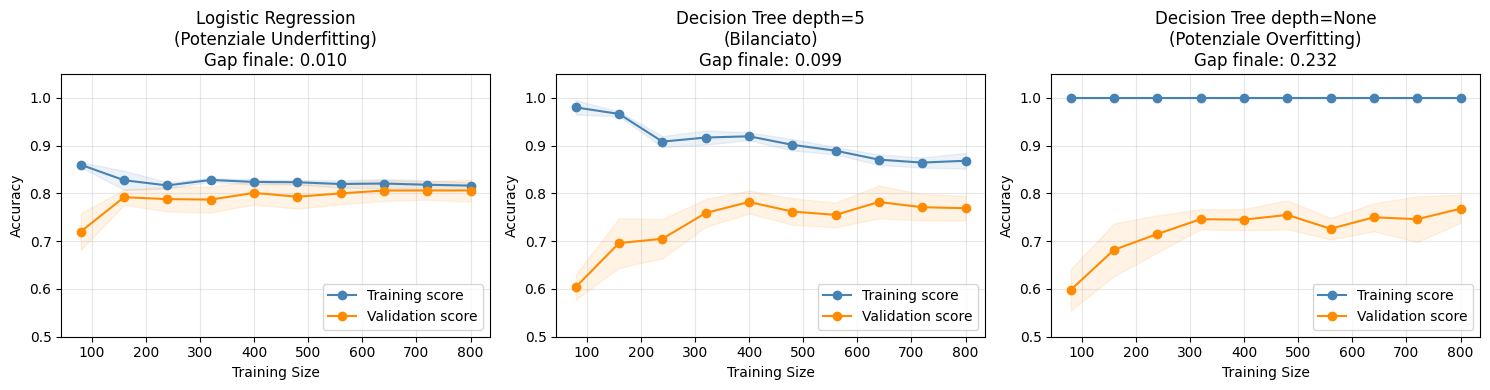

COME LEGGERE LE LEARNING CURVES

LOGISTIC REGRESSION:
• Training e Validation convergono a un valore MEDIO
• Gap piccolo → non c'è overfitting
• Ma il punteggio finale non è altissimo
• Potrebbe essere UNDERFITTING (modello troppo semplice per i dati)

DECISION TREE (depth=5):
• Training e Validation convergono bene
• Gap moderato → buon compromesso
• Punteggio finale buono
• Questo è il comportamento DESIDERATO

DECISION TREE (depth=None):
• Training score ALTISSIMO (vicino a 1.0)
• Validation score SIGNIFICATIVAMENTE più basso
• Grande GAP → OVERFITTING!
• Il modello memorizza i dati di training

REGOLA PRATICA:
- Gap grande → riduci complessità del modello
- Entrambi bassi → aumenta complessità del modello
- Entrambi convergono a buon valore → modello ok



In [2]:
# Dimostrazione: Learning Curves per Diagnosticare Overfitting

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Creiamo un dataset
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    flip_y=0.1,
    random_state=42
)

# Tre modelli con complessità crescente
models = {
    'Logistic Regression\n(Potenziale Underfitting)': LogisticRegression(max_iter=1000),
    'Decision Tree depth=5\n(Bilanciato)': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Decision Tree depth=None\n(Potenziale Overfitting)': DecisionTreeClassifier(max_depth=None, random_state=42)
}

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, model) in zip(axes, models.items()):
    # Calcola learning curves
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )
    
    # Medie e deviazioni standard
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)
    
    # Plot
    ax.plot(train_sizes, train_mean, 'o-', color='steelblue', label='Training score')
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                     alpha=0.1, color='steelblue')
    
    ax.plot(train_sizes, val_mean, 'o-', color='darkorange', label='Validation score')
    ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                     alpha=0.1, color='darkorange')
    
    # Gap finale
    gap = train_mean[-1] - val_mean[-1]
    
    ax.set_xlabel('Training Size')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'{name}\nGap finale: {gap:.3f}')
    ax.legend(loc='lower right')
    ax.set_ylim(0.5, 1.05)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Interpretazione
print("="*70)
print("COME LEGGERE LE LEARNING CURVES")
print("="*70)
print("""
LOGISTIC REGRESSION:
• Training e Validation convergono a un valore MEDIO
• Gap piccolo → non c'è overfitting
• Ma il punteggio finale non è altissimo
• Potrebbe essere UNDERFITTING (modello troppo semplice per i dati)

DECISION TREE (depth=5):
• Training e Validation convergono bene
• Gap moderato → buon compromesso
• Punteggio finale buono
• Questo è il comportamento DESIDERATO

DECISION TREE (depth=None):
• Training score ALTISSIMO (vicino a 1.0)
• Validation score SIGNIFICATIVAMENTE più basso
• Grande GAP → OVERFITTING!
• Il modello memorizza i dati di training

REGOLA PRATICA:
- Gap grande → riduci complessità del modello
- Entrambi bassi → aumenta complessità del modello
- Entrambi convergono a buon valore → modello ok
""")

# Section 4 — Segnali Pratici nei Dati

## Come Riconoscere Overfitting e Underfitting

### 📊 Tabella Diagnostica

| Segnale | Underfitting | Overfitting |
|---------|--------------|-------------|
| Errore Training | Alto | Basso |
| Errore Test/Val | Alto | Alto |
| Gap Train-Test | Piccolo | Grande |
| Learning Curve | Entrambe basse | Train alta, Val bassa |
| Cross-Val Std | Bassa | Alta |

### 🔴 Red Flags per Overfitting

1. **Accuracy training ≈ 100%** ma validation molto più bassa
2. **Grande variabilità** tra i fold della cross-validation
3. **Modello molto complesso** rispetto alla quantità di dati
4. **Troppe feature** rispetto ai campioni (p >> n)
5. **Iperparametri non regolati** (es. albero senza max_depth)

### 🔵 Red Flags per Underfitting

1. **Performance deludente** anche sul training set
2. **Modello troppo semplice** per il problema
3. **Feature poco informative** o mancanti
4. **Preprocessing inadeguato** (es. dati non scalati per modelli lineari)

## Rimedi

### Per Overfitting (Ridurre Varianza)

| Strategia | Come Funziona |
|-----------|---------------|
| Più dati | Più campioni = meno memorizzazione |
| Regolarizzazione | Penalizza complessità (L1, L2) |
| Ridurre complessità | Meno parametri, max_depth, min_samples |
| Ensemble | Random Forest, Bagging riducono varianza |
| Early stopping | Ferma training prima che memorizzi |
| Dropout (DL) | Disattiva neuroni casualmente |

### Per Underfitting (Ridurre Bias)

| Strategia | Come Funziona |
|-----------|---------------|
| Modello più complesso | Più parametri, reti più profonde |
| Più feature | Feature engineering |
| Meno regolarizzazione | Riduci penalità |
| Train più a lungo | Più epoche/iterazioni |
| Preprocessing migliore | Scaling, encoding corretti |

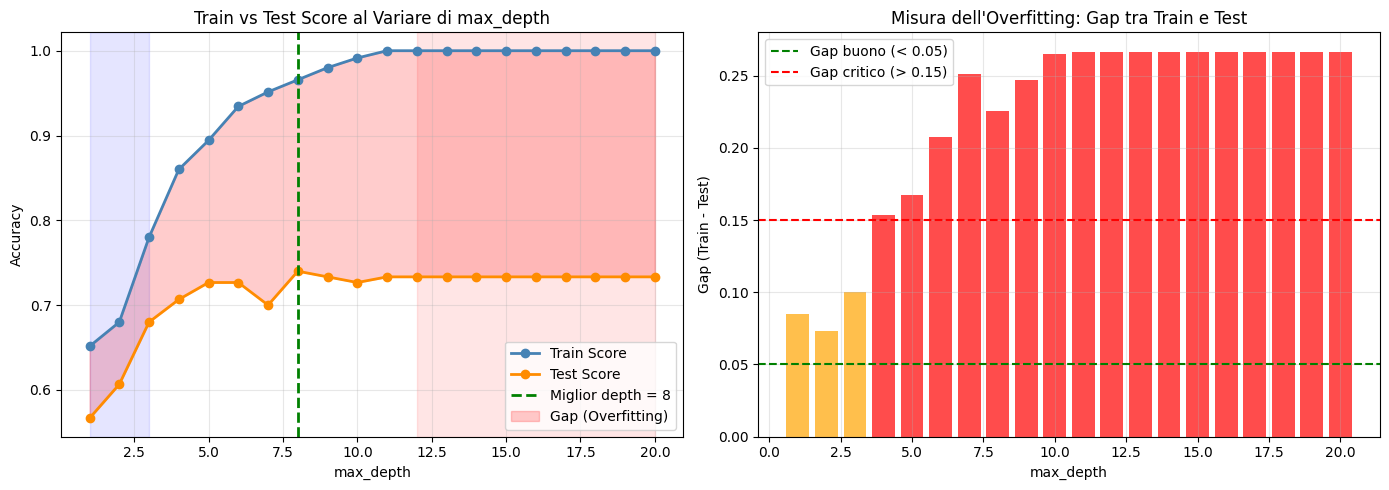

ANALISI DEL TRADE-OFF BIAS-VARIANZA

Miglior max_depth: 8 (Test Accuracy: 0.740)

Depth=1:  Train=0.651, Test=0.567, Gap=0.085
Depth=8:  Train=0.966, Test=0.740, Gap=0.226
Depth=20: Train=1.000, Test=0.733, Gap=0.267

CONCLUSIONI:
• Depth basso → Underfitting (entrambi i punteggi bassi)
• Depth ottimo → Buon compromesso (test score massimo)
• Depth alto → Overfitting (train perfetto, test cala)



In [3]:
# Dimostrazione: Train vs Test Score al Variare della Complessità

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Dataset
X, y = make_classification(
    n_samples=500,
    n_features=15,
    n_informative=8,
    flip_y=0.1,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Testiamo diversi valori di max_depth
depths = range(1, 21)
train_scores = []
test_scores = []

for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))

# Trova il miglior depth
best_depth = depths[np.argmax(test_scores)]
best_score = max(test_scores)

# Visualizzazione
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Train vs Test Score
ax1 = axes[0]
ax1.plot(depths, train_scores, 'o-', color='steelblue', linewidth=2, label='Train Score')
ax1.plot(depths, test_scores, 'o-', color='darkorange', linewidth=2, label='Test Score')
ax1.axvline(best_depth, color='green', linestyle='--', linewidth=2, 
             label=f'Miglior depth = {best_depth}')
ax1.fill_between(depths, train_scores, test_scores, alpha=0.2, color='red', 
                  label='Gap (Overfitting)')
ax1.set_xlabel('max_depth')
ax1.set_ylabel('Accuracy')
ax1.set_title('Train vs Test Score al Variare di max_depth')
ax1.legend()
ax1.grid(alpha=0.3)

# Annotazioni zone
ax1.axvspan(1, 3, alpha=0.1, color='blue', label='Underfitting')
ax1.axvspan(12, 20, alpha=0.1, color='red', label='Overfitting')

# Plot 2: Gap (Train - Test)
ax2 = axes[1]
gaps = np.array(train_scores) - np.array(test_scores)
colors = ['green' if g < 0.05 else 'orange' if g < 0.15 else 'red' for g in gaps]
ax2.bar(depths, gaps, color=colors, alpha=0.7)
ax2.axhline(0.05, color='green', linestyle='--', label='Gap buono (< 0.05)')
ax2.axhline(0.15, color='red', linestyle='--', label='Gap critico (> 0.15)')
ax2.set_xlabel('max_depth')
ax2.set_ylabel('Gap (Train - Test)')
ax2.set_title('Misura dell\'Overfitting: Gap tra Train e Test')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Report
print("="*70)
print("ANALISI DEL TRADE-OFF BIAS-VARIANZA")
print("="*70)
print(f"\nMiglior max_depth: {best_depth} (Test Accuracy: {best_score:.3f})")
print(f"\nDepth=1:  Train={train_scores[0]:.3f}, Test={test_scores[0]:.3f}, Gap={train_scores[0]-test_scores[0]:.3f}")
print(f"Depth={best_depth}:  Train={train_scores[best_depth-1]:.3f}, Test={test_scores[best_depth-1]:.3f}, Gap={train_scores[best_depth-1]-test_scores[best_depth-1]:.3f}")
print(f"Depth=20: Train={train_scores[-1]:.3f}, Test={test_scores[-1]:.3f}, Gap={train_scores[-1]-test_scores[-1]:.3f}")

print("""
CONCLUSIONI:
• Depth basso → Underfitting (entrambi i punteggi bassi)
• Depth ottimo → Buon compromesso (test score massimo)
• Depth alto → Overfitting (train perfetto, test cala)
""")

# Section 5 — Schema Mentale: Diagnosi e Rimedi

## 🧠 Decision Tree per la Diagnosi

```
HO ADDESTRATO UN MODELLO
          │
          ▼
    ┌─────────────────┐
    │ Train Score     │
    │    alto?        │
    └────────┬────────┘
             │
     ┌───────┴───────┐
     │               │
    NO              SÌ
     │               │
     ▼               ▼
┌─────────┐    ┌─────────────┐
│UNDERFITTING│   │Test Score  │
│           │    │alto?       │
│ Aumenta   │    └─────┬──────┘
│complessità│          │
└─────────┘     ┌──────┴──────┐
                │             │
               SÌ            NO
                │             │
                ▼             ▼
          ┌─────────┐   ┌─────────────┐
          │ OTTIMO! │   │OVERFITTING  │
          │         │   │             │
          │ Modello │   │ Riduci      │
          │generalizza│  │complessità  │
          └─────────┘   │o più dati   │
                        └─────────────┘
```

## 📋 Checklist Pratica

### Prima di Allenare
- [ ] Ho abbastanza dati rispetto alle feature?
- [ ] Ho fatto train/test split PRIMA del preprocessing?
- [ ] Ho scelto un modello con complessità ragionevole?

### Dopo l'Allenamento
- [ ] Train score ragionevole (non troppo alto, non troppo basso)?
- [ ] Gap train-test accettabile (< 5-10%)?
- [ ] Cross-validation con std bassa?

### Se Overfitting
- [ ] Prova a ridurre max_depth (alberi)
- [ ] Prova a aumentare min_samples_leaf
- [ ] Aggiungi regolarizzazione
- [ ] Rimuovi feature poco importanti
- [ ] Raccogli più dati

### Se Underfitting
- [ ] Prova un modello più complesso
- [ ] Aggiungi feature engineering
- [ ] Riduci regolarizzazione
- [ ] Controlla preprocessing

# Section 6 — Esercizi SVOLTI

Gli esercizi che seguono sono **completamente risolti** con spiegazioni passo-passo.

---

## Esercizio 12.1: Identificare Overfitting vs Underfitting

**Obiettivo:** Dato un modello e le sue performance, diagnosticare se c'è overfitting, underfitting, o buona generalizzazione.

**Procedura:**
1. Creare un dataset
2. Allenare tre modelli con complessità diversa
3. Calcolare train/test score e gap
4. Diagnosticare ogni modello

STEP 1: Creazione Dataset
--------------------------------------------------
Training set: 560 campioni
Test set: 240 campioni
Feature: 20

STEP 2: Definizione Modelli
--------------------------------------------------
Modello A: Albero molto semplice (max_depth=2)
Modello B: Albero moderato (max_depth=6)
Modello C: Albero senza limiti (max_depth=None)

STEP 3: Training e Valutazione

Modello A: Decision Tree (max_depth=2)
  Train Score:  0.7714
  Test Score:   0.7125
  Gap:          0.0589
  CV Std:       0.0360

Modello B: Decision Tree (max_depth=6)
  Train Score:  0.9268
  Test Score:   0.8250
  Gap:          0.1018
  CV Std:       0.0222

Modello C: Decision Tree (max_depth=None)
  Train Score:  1.0000
  Test Score:   0.7667
  Gap:          0.2333
  CV Std:       0.0278

STEP 4: DIAGNOSI

Modello A: Decision Tree (max_depth=2)
  DIAGNOSI: UNDERFITTING
  Spiegazione: Train score troppo basso. Il modello è troppo semplice.
  Azione: → Aumenta max_depth o usa modello più complesso

M

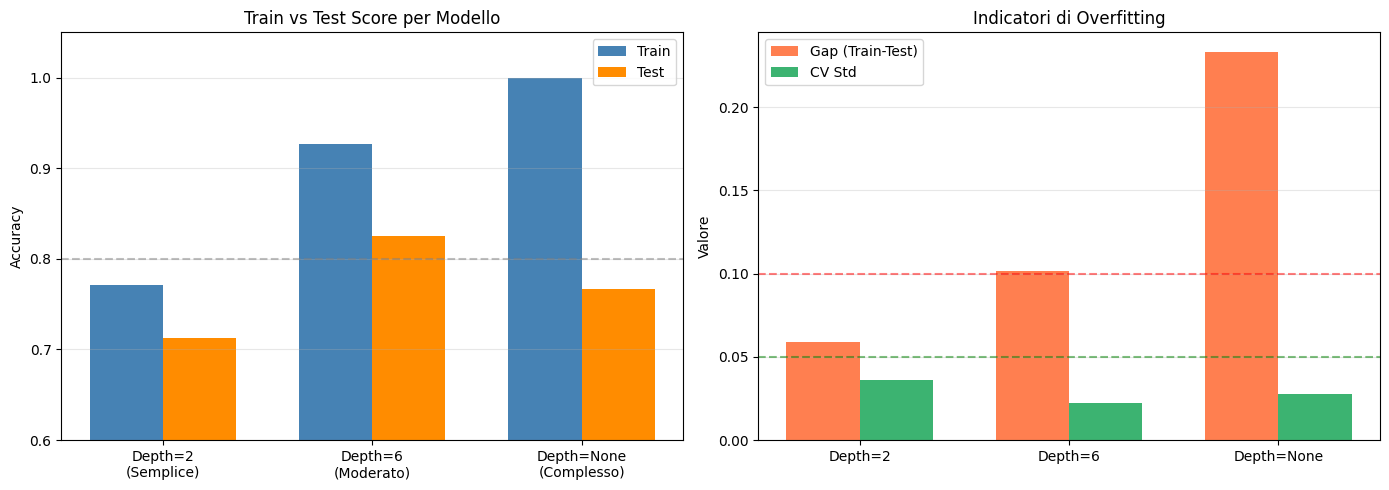


CONCLUSIONE: Il Modello B (depth=6) è il migliore!
Ha il miglior test score con gap accettabile.


In [4]:
# ============================================================================
# ESERCIZIO 12.1 — Identificare Overfitting vs Underfitting
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# STEP 1: Creiamo il dataset
# ---------------------------------------------------------------------------
print("STEP 1: Creazione Dataset")
print("-" * 50)

X, y = make_classification(
    n_samples=800,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    flip_y=0.05,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"Training set: {X_train.shape[0]} campioni")
print(f"Test set: {X_test.shape[0]} campioni")
print(f"Feature: {X.shape[1]}")

# STEP 2: Definiamo tre modelli con complessità diversa
# ---------------------------------------------------------------------------
print("\nSTEP 2: Definizione Modelli")
print("-" * 50)

models = {
    'Modello A: Decision Tree (max_depth=2)': DecisionTreeClassifier(max_depth=2, random_state=42),
    'Modello B: Decision Tree (max_depth=6)': DecisionTreeClassifier(max_depth=6, random_state=42),
    'Modello C: Decision Tree (max_depth=None)': DecisionTreeClassifier(max_depth=None, random_state=42)
}

print("Modello A: Albero molto semplice (max_depth=2)")
print("Modello B: Albero moderato (max_depth=6)")
print("Modello C: Albero senza limiti (max_depth=None)")

# STEP 3: Alleniamo e valutiamo ogni modello
# ---------------------------------------------------------------------------
print("\nSTEP 3: Training e Valutazione")
print("=" * 70)

results = []

for name, model in models.items():
    # Allena
    model.fit(X_train, y_train)
    
    # Calcola score
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    gap = train_score - test_score
    
    # Cross-validation per std
    cv_scores = cross_val_score(model, X, y, cv=5)
    cv_std = cv_scores.std()
    
    results.append({
        'name': name,
        'train': train_score,
        'test': test_score,
        'gap': gap,
        'cv_std': cv_std
    })
    
    print(f"\n{name}")
    print(f"  Train Score:  {train_score:.4f}")
    print(f"  Test Score:   {test_score:.4f}")
    print(f"  Gap:          {gap:.4f}")
    print(f"  CV Std:       {cv_std:.4f}")

# STEP 4: Diagnosi
# ---------------------------------------------------------------------------
print("\n" + "=" * 70)
print("STEP 4: DIAGNOSI")
print("=" * 70)

for r in results:
    print(f"\n{r['name']}")
    
    # Logica di diagnosi
    if r['train'] < 0.80:
        diagnosis = "UNDERFITTING"
        explanation = "Train score troppo basso. Il modello è troppo semplice."
        action = "→ Aumenta max_depth o usa modello più complesso"
    elif r['gap'] > 0.10:
        diagnosis = "OVERFITTING"
        explanation = "Gap train-test troppo grande. Il modello memorizza."
        action = "→ Riduci max_depth o aggiungi regolarizzazione"
    else:
        diagnosis = "BUONA GENERALIZZAZIONE"
        explanation = "Train e test score alti e vicini."
        action = "→ Modello pronto per produzione"
    
    print(f"  DIAGNOSI: {diagnosis}")
    print(f"  Spiegazione: {explanation}")
    print(f"  Azione: {action}")

# STEP 5: Visualizzazione
# ---------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot train vs test
ax1 = axes[0]
x = np.arange(3)
width = 0.35
train_vals = [r['train'] for r in results]
test_vals = [r['test'] for r in results]

bars1 = ax1.bar(x - width/2, train_vals, width, label='Train', color='steelblue')
bars2 = ax1.bar(x + width/2, test_vals, width, label='Test', color='darkorange')

ax1.set_ylabel('Accuracy')
ax1.set_title('Train vs Test Score per Modello')
ax1.set_xticks(x)
ax1.set_xticklabels(['Depth=2\n(Semplice)', 'Depth=6\n(Moderato)', 'Depth=None\n(Complesso)'])
ax1.legend()
ax1.set_ylim(0.6, 1.05)
ax1.axhline(0.8, color='gray', linestyle='--', alpha=0.5, label='Soglia buon train')
ax1.grid(axis='y', alpha=0.3)

# Gap e CV std
ax2 = axes[1]
gaps = [r['gap'] for r in results]
cv_stds = [r['cv_std'] for r in results]

ax2.bar(x - width/2, gaps, width, label='Gap (Train-Test)', color='coral')
ax2.bar(x + width/2, cv_stds, width, label='CV Std', color='mediumseagreen')

ax2.set_ylabel('Valore')
ax2.set_title('Indicatori di Overfitting')
ax2.set_xticks(x)
ax2.set_xticklabels(['Depth=2', 'Depth=6', 'Depth=None'])
ax2.legend()
ax2.axhline(0.05, color='green', linestyle='--', alpha=0.5, label='Soglia OK')
ax2.axhline(0.10, color='red', linestyle='--', alpha=0.5, label='Soglia critica')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCONCLUSIONE: Il Modello B (depth=6) è il migliore!")
print("Ha il miglior test score con gap accettabile.")

---

## Esercizio 12.2: Learning Curve Completa

**Obiettivo:** Costruire e interpretare una learning curve per diagnosticare problemi di generalizzazione.

**Procedura:**
1. Creare un dataset
2. Generare la learning curve con `learning_curve` di sklearn
3. Visualizzare train e validation score
4. Determinare se servono più dati o un modello diverso

STEP 1: Creazione Dataset
--------------------------------------------------
Dataset: 2000 campioni, 20 feature

STEP 2: Generazione Learning Curve
--------------------------------------------------
Training sizes testati: [ 160  320  480  640  800  960 1120 1280 1440 1600]
Shape train_scores: (10, 5) (sizes x folds)

STEP 3: Analisi dei Risultati

  Train Size   Train Mean    Train Std     Val Mean      Val Std      Gap
------------------------------------------------------------------------
         160       1.0000       0.0000       0.8140       0.0131   0.1860
         320       1.0000       0.0000       0.8245       0.0183   0.1755
         480       1.0000       0.0000       0.8330       0.0161   0.1670
         640       0.9981       0.0006       0.8465       0.0215   0.1516
         800       0.9957       0.0020       0.8595       0.0272   0.1362
         960       0.9940       0.0020       0.8610       0.0181   0.1330
        1120       0.9904       0.0028       0.8640       

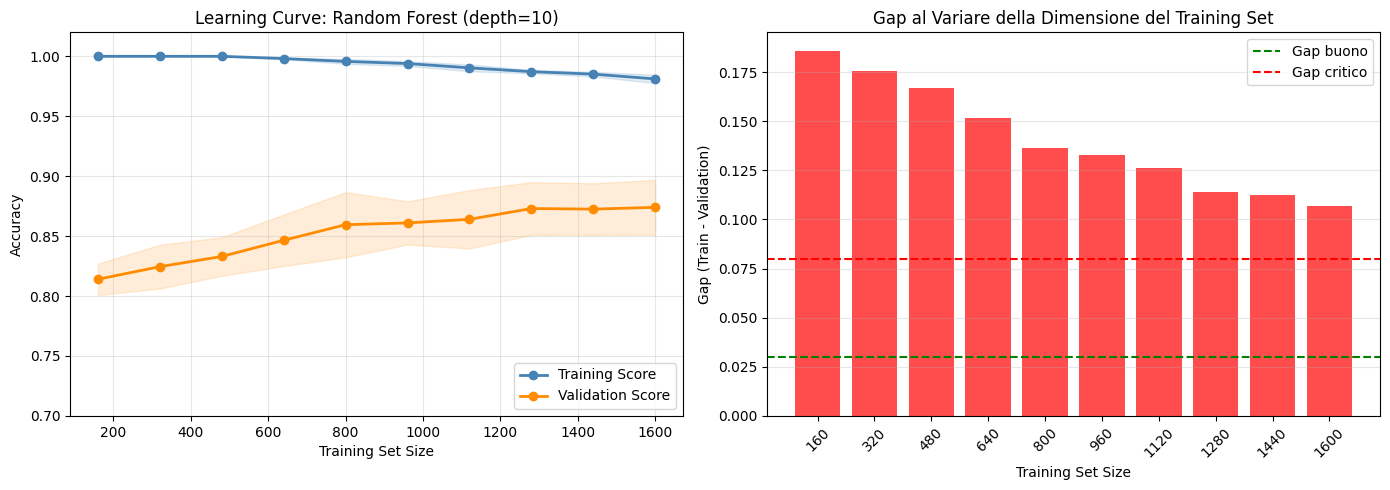


STEP 5: INTERPRETAZIONE

Performance finale (con tutti i dati):
• Training Score: 0.9811
• Validation Score: 0.8740
• Gap: 0.1071

🔴 DIAGNOSI: Overfitting significativo
   Gap grande = il modello sta memorizzando
   Azione: riduci max_depth, aumenta min_samples_leaf

ANALISI DELLA TENDENZA:
• La validation accuracy sta ancora CRESCENDO con più dati
• → PIÙ DATI potrebbero aiutare


In [5]:
# ============================================================================
# ESERCIZIO 12.2 — Learning Curve Completa
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier

# STEP 1: Creiamo il dataset
# ---------------------------------------------------------------------------
print("STEP 1: Creazione Dataset")
print("-" * 50)

X, y = make_classification(
    n_samples=2000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    flip_y=0.08,
    random_state=42
)

print(f"Dataset: {X.shape[0]} campioni, {X.shape[1]} feature")

# STEP 2: Scegliamo un modello e generiamo la learning curve
# ---------------------------------------------------------------------------
print("\nSTEP 2: Generazione Learning Curve")
print("-" * 50)

model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)

# Definiamo le dimensioni del training set da testare
train_sizes_rel = np.linspace(0.1, 1.0, 10)  # Dal 10% al 100%

# Calcola learning curve
train_sizes_abs, train_scores, val_scores = learning_curve(
    model, X, y,
    train_sizes=train_sizes_rel,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

print(f"Training sizes testati: {train_sizes_abs}")
print(f"Shape train_scores: {train_scores.shape} (sizes x folds)")

# STEP 3: Calcola statistiche
# ---------------------------------------------------------------------------
print("\nSTEP 3: Analisi dei Risultati")
print("=" * 70)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Tabella risultati
print(f"\n{'Train Size':>12} {'Train Mean':>12} {'Train Std':>12} {'Val Mean':>12} {'Val Std':>12} {'Gap':>8}")
print("-" * 72)
for i, size in enumerate(train_sizes_abs):
    gap = train_mean[i] - val_mean[i]
    print(f"{size:>12} {train_mean[i]:>12.4f} {train_std[i]:>12.4f} "
          f"{val_mean[i]:>12.4f} {val_std[i]:>12.4f} {gap:>8.4f}")

# STEP 4: Visualizzazione
# ---------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Learning Curve
ax1 = axes[0]
ax1.plot(train_sizes_abs, train_mean, 'o-', color='steelblue', linewidth=2, 
         markersize=6, label='Training Score')
ax1.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, 
                  alpha=0.15, color='steelblue')

ax1.plot(train_sizes_abs, val_mean, 'o-', color='darkorange', linewidth=2, 
         markersize=6, label='Validation Score')
ax1.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, 
                  alpha=0.15, color='darkorange')

ax1.set_xlabel('Training Set Size')
ax1.set_ylabel('Accuracy')
ax1.set_title('Learning Curve: Random Forest (depth=10)')
ax1.legend(loc='lower right')
ax1.grid(alpha=0.3)
ax1.set_ylim(0.7, 1.02)

# Gap plot
ax2 = axes[1]
gaps = train_mean - val_mean
colors = ['green' if g < 0.03 else 'orange' if g < 0.08 else 'red' for g in gaps]
ax2.bar(range(len(train_sizes_abs)), gaps, color=colors, alpha=0.7)
ax2.set_xticks(range(len(train_sizes_abs)))
ax2.set_xticklabels([str(s) for s in train_sizes_abs], rotation=45)
ax2.set_xlabel('Training Set Size')
ax2.set_ylabel('Gap (Train - Validation)')
ax2.set_title('Gap al Variare della Dimensione del Training Set')
ax2.axhline(0.03, color='green', linestyle='--', label='Gap buono')
ax2.axhline(0.08, color='red', linestyle='--', label='Gap critico')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# STEP 5: Interpretazione
# ---------------------------------------------------------------------------
print("\n" + "=" * 70)
print("STEP 5: INTERPRETAZIONE")
print("=" * 70)

final_gap = train_mean[-1] - val_mean[-1]
final_val = val_mean[-1]

print(f"""
Performance finale (con tutti i dati):
• Training Score: {train_mean[-1]:.4f}
• Validation Score: {val_mean[-1]:.4f}
• Gap: {final_gap:.4f}
""")

if final_gap < 0.03:
    print("✅ DIAGNOSI: Buona generalizzazione")
    print("   Gap piccolo = il modello non sta overfittando")
    print("   Le curve sono vicine e stabili")
elif final_gap < 0.08:
    print("⚠️ DIAGNOSI: Leggero overfitting")
    print("   Gap moderato = c'è margine di miglioramento")
    print("   Considera: ridurre complessità o più dati")
else:
    print("🔴 DIAGNOSI: Overfitting significativo")
    print("   Gap grande = il modello sta memorizzando")
    print("   Azione: riduci max_depth, aumenta min_samples_leaf")

# Analisi tendenza
print("\nANALISI DELLA TENDENZA:")
if val_mean[-1] > val_mean[-2]:
    print("• La validation accuracy sta ancora CRESCENDO con più dati")
    print("• → PIÙ DATI potrebbero aiutare")
else:
    print("• La validation accuracy si è STABILIZZATA")
    print("• → Più dati probabilmente NON aiuteranno molto")

---

## Esercizio 12.3: Trovare la Complessità Ottimale

**Obiettivo:** Usare la validation per trovare il valore ottimale di un iperparametro.

**Procedura:**
1. Testare diversi valori di `max_depth` per un Decision Tree
2. Per ogni valore, calcolare train e test score
3. Identificare il punto di overfitting
4. Scegliere il valore ottimale

STEP 1: Creazione Dataset
--------------------------------------------------
Training set: 1125 campioni
Test set: 375 campioni

STEP 2: Ricerca del max_depth Ottimale

 Depth      Train       Test        Gap          Status
-------------------------------------------------------
     1     0.6204     0.5947     0.0258    Underfitting
     2     0.6302     0.6027     0.0276    Underfitting
     3     0.7289     0.6987     0.0302    Underfitting
     4     0.7680     0.7413     0.0267    Underfitting
     5     0.7956     0.7413     0.0542    Underfitting
     6     0.8480     0.7573     0.0907              OK
     7     0.8711     0.7493     0.1218     Overfitting
     8     0.9129     0.7547     0.1582     Overfitting
     9     0.9378     0.7947     0.1431     Overfitting
    10     0.9556     0.7600     0.1956     Overfitting
    11     0.9787     0.7813     0.1973     Overfitting
    12     0.9920     0.8027     0.1893     Overfitting
    13     0.9964     0.7947     0.2018     Ove

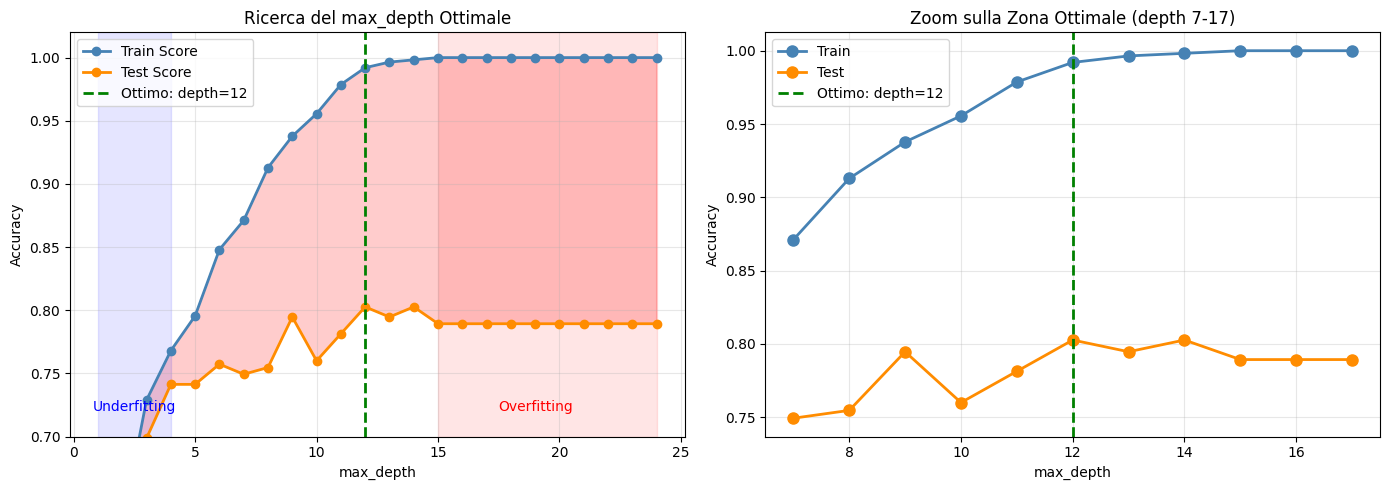


STEP 5: Verifica con Cross-Validation
--------------------------------------------------
Cross-Validation Scores: ['0.747', '0.810', '0.777', '0.760', '0.800']
CV Mean: 0.7787 ± 0.0237

CONCLUSIONE:
• Il depth ottimale è 12
• A depth inferiori c'è underfitting
• A depth superiori inizia l'overfitting
• La cross-validation conferma la robustezza della scelta



In [6]:
# ============================================================================
# ESERCIZIO 12.3 — Trovare la Complessità Ottimale
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier

# STEP 1: Creiamo il dataset
# ---------------------------------------------------------------------------
print("STEP 1: Creazione Dataset")
print("-" * 50)

X, y = make_classification(
    n_samples=1500,
    n_features=15,
    n_informative=8,
    n_redundant=4,
    flip_y=0.08,
    random_state=42
)

# Usiamo un validation set separato
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print(f"Training set: {len(y_train)} campioni")
print(f"Test set: {len(y_test)} campioni")

# STEP 2: Testiamo diversi valori di max_depth
# ---------------------------------------------------------------------------
print("\nSTEP 2: Ricerca del max_depth Ottimale")
print("=" * 70)

depths = range(1, 25)
results = []

print(f"\n{'Depth':>6} {'Train':>10} {'Test':>10} {'Gap':>10} {'Status':>15}")
print("-" * 55)

for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    gap = train_score - test_score
    
    # Determina status
    if train_score < 0.80:
        status = "Underfitting"
    elif gap > 0.10:
        status = "Overfitting"
    else:
        status = "OK"
    
    results.append({
        'depth': depth,
        'train': train_score,
        'test': test_score,
        'gap': gap,
        'status': status
    })
    
    print(f"{depth:>6} {train_score:>10.4f} {test_score:>10.4f} {gap:>10.4f} {status:>15}")

# STEP 3: Trova il depth ottimale
# ---------------------------------------------------------------------------
print("\n" + "=" * 70)
print("STEP 3: Identificazione Depth Ottimale")
print("=" * 70)

# Il depth ottimale è quello con il test score più alto
test_scores = [r['test'] for r in results]
best_idx = np.argmax(test_scores)
best_depth = results[best_idx]['depth']
best_test_score = results[best_idx]['test']

# Trova il punto di overfitting (dove test inizia a calare)
overfitting_start = None
for i in range(1, len(results)):
    if results[i]['test'] < results[i-1]['test'] and results[i]['gap'] > 0.08:
        overfitting_start = results[i]['depth']
        break

print(f"\n✅ DEPTH OTTIMALE: {best_depth}")
print(f"   Test Accuracy: {best_test_score:.4f}")
print(f"   Train Accuracy: {results[best_idx]['train']:.4f}")
print(f"   Gap: {results[best_idx]['gap']:.4f}")

if overfitting_start:
    print(f"\n⚠️ Overfitting inizia a depth = {overfitting_start}")

# STEP 4: Visualizzazione
# ---------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train vs Test
ax1 = axes[0]
depths_list = [r['depth'] for r in results]
train_scores_list = [r['train'] for r in results]
test_scores_list = [r['test'] for r in results]

ax1.plot(depths_list, train_scores_list, 'o-', color='steelblue', 
         linewidth=2, label='Train Score')
ax1.plot(depths_list, test_scores_list, 'o-', color='darkorange', 
         linewidth=2, label='Test Score')
ax1.axvline(best_depth, color='green', linestyle='--', linewidth=2, 
            label=f'Ottimo: depth={best_depth}')
ax1.fill_between(depths_list, train_scores_list, test_scores_list, 
                  alpha=0.2, color='red')

# Zone
ax1.axvspan(1, 4, alpha=0.1, color='blue')
ax1.axvspan(15, 24, alpha=0.1, color='red')
ax1.text(2.5, 0.72, 'Underfitting', ha='center', fontsize=10, color='blue')
ax1.text(19, 0.72, 'Overfitting', ha='center', fontsize=10, color='red')

ax1.set_xlabel('max_depth')
ax1.set_ylabel('Accuracy')
ax1.set_title('Ricerca del max_depth Ottimale')
ax1.legend()
ax1.grid(alpha=0.3)
ax1.set_ylim(0.7, 1.02)

# Dettaglio zona ottimale
ax2 = axes[1]
zoom_range = range(max(1, best_depth-5), min(25, best_depth+6))
zoom_results = [r for r in results if r['depth'] in zoom_range]

x = [r['depth'] for r in zoom_results]
ax2.plot(x, [r['train'] for r in zoom_results], 'o-', color='steelblue', 
         linewidth=2, markersize=8, label='Train')
ax2.plot(x, [r['test'] for r in zoom_results], 'o-', color='darkorange', 
         linewidth=2, markersize=8, label='Test')
ax2.axvline(best_depth, color='green', linestyle='--', linewidth=2, 
            label=f'Ottimo: depth={best_depth}')

ax2.set_xlabel('max_depth')
ax2.set_ylabel('Accuracy')
ax2.set_title(f'Zoom sulla Zona Ottimale (depth {min(x)}-{max(x)})')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# STEP 5: Verifica con Cross-Validation
# ---------------------------------------------------------------------------
print("\nSTEP 5: Verifica con Cross-Validation")
print("-" * 50)

final_model = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
cv_scores = cross_val_score(final_model, X, y, cv=5)

print(f"Cross-Validation Scores: {[f'{s:.3f}' for s in cv_scores]}")
print(f"CV Mean: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

print(f"""
CONCLUSIONE:
• Il depth ottimale è {best_depth}
• A depth inferiori c'è underfitting
• A depth superiori inizia l'overfitting
• La cross-validation conferma la robustezza della scelta
""")

# Conclusione

## Concetti Chiave Appresi

### 1. Il Trade-Off Bias-Varianza
- **Bias** = errore sistematico (modello troppo semplice)
- **Varianza** = sensibilità ai dati (modello troppo complesso)
- Non puoi minimizzare entrambi: devi trovare il compromesso

### 2. Overfitting e Underfitting
| Problema | Train Score | Test Score | Gap | Rimedio |
|----------|-------------|------------|-----|---------|
| Underfitting | Basso | Basso | Piccolo | Aumenta complessità |
| Overfitting | Alto | Basso | Grande | Riduci complessità |
| Giusto | Alto | Alto | Piccolo | Mantieni |

### 3. Learning Curves
- Mostrano come cambiano train e val score con più dati
- Gap grande = overfitting
- Entrambi bassi = underfitting
- Utili per decidere se servono più dati

### 4. Segnali Pratici
- Accuracy training ≈ 100% → sospetto overfitting
- Grande variabilità nei fold CV → overfitting
- Score deludente anche su training → underfitting

---

## Appendice — Bignami

```python
# ═══════════════════════════════════════════════════════════════
# LEZIONE 12: OVERFITTING E UNDERFITTING
# ═══════════════════════════════════════════════════════════════

from sklearn.model_selection import learning_curve, cross_val_score

# ─────────────────────────────────────────────────────────────────
# DIAGNOSTICA BASE
# ─────────────────────────────────────────────────────────────────
model.fit(X_train, y_train)
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
gap = train_score - test_score

if train_score < 0.80:
    print("Underfitting: aumenta complessità")
elif gap > 0.10:
    print("Overfitting: riduci complessità")
else:
    print("OK: buona generalizzazione")

# ─────────────────────────────────────────────────────────────────
# LEARNING CURVE
# ─────────────────────────────────────────────────────────────────
train_sizes, train_scores, val_scores = learning_curve(
    model, X, y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy'
)

# Medie
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

# Se train alta, val bassa → overfitting
# Se entrambe basse → underfitting
# Se entrambe alte e vicine → ok

# ─────────────────────────────────────────────────────────────────
# RICERCA IPERPARAMETRO OTTIMALE
# ─────────────────────────────────────────────────────────────────
for depth in range(1, 20):
    model = DecisionTreeClassifier(max_depth=depth)
    model.fit(X_train, y_train)
    test_score = model.score(X_test, y_test)
    # Scegli il depth con test_score massimo

# ─────────────────────────────────────────────────────────────────
# REGOLE D'ORO
# ─────────────────────────────────────────────────────────────────
# 1. Mai valutare solo sul training set
# 2. Gap > 10% = campanello d'allarme
# 3. Usa sempre cross-validation
# 4. Più dati aiutano contro overfitting
# 5. Regolarizzazione aiuta contro overfitting
```